Analysis code for

# Prevalence of delusional themes among patients with psychosis: a systematic review and meta-analysis

Including all data, including from ad-hoc and clinical assessments

In [1]:
library(metafor)
library(dplyr)
library(stringr)
library(forester)   # from https://github.com/rdboyes/forester
library(dmetar)     # from https://dmetar.protectlab.org/articles/dmetar
library(doParallel)
library(clubSandwich)
library(mutoss)
library(table1)
library(flextable)
library(tibble)
library(IRdisplay)

Loading required package: Matrix

Loading required package: metadat

Loading required package: numDeriv


Loading the 'metafor' package (version 4.4-0). For an
introduction to the package please type: help(metafor)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Extensive documentation for the dmetar package can be found at: 
 www.bookdown.org/MathiasHarrer/Doing_Meta_Analysis_in_R/

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

Registered S3 method overwritten by 'clubSandwich':
  method    from    
  bread.mlm sandwich

Loading required package: mvtnorm


Attaching package: ‘table1’


The following objects are masked from ‘package:base’:

    units, units<-




In [2]:
data_dir <- "/home/main/data/"
output_dir <- "/home/main/data/figures/"

In [3]:
# Make sure we're using the metafor harmonic mean of sample sizes back-transformation
transf.ipft.hm <- metafor::transf.ipft.hm

Read in data files

In [4]:
# Read data
theme_data_filename <- paste(data_dir, "delusion_theme_meta_data.csv", sep = "")
delus_themes_data_raw <- read.csv(theme_data_filename, header = TRUE)

human_friendly_labels_filename <- paste(data_dir, "HumanFriendlyLabels.csv", sep = "")
human_friendly_labels <- read.csv(human_friendly_labels_filename, header = TRUE)

Do some tidying up of data

In [5]:
# Correct all theme names by removing "n_" prefix
delus_themes_data_raw <- delus_themes_data_raw %>% 
  mutate(theme = str_replace(theme, "n_",""))

# Add effect size ID (row ID) column for hierarchical clustering
delus_themes_data_raw <- delus_themes_data_raw %>% 
  mutate(es_id = paste0("id_", row_number()))

# Remove 'other' categories
delus_themes_data <- delus_themes_data_raw %>% 
  filter(theme != "other") %>%
  filter(theme != "anydelusion") %>%
  filter(theme != "unspecified")

Function for running meta-analysis

In [6]:
#
# run_meta: Function to run multivariate, multilevel meta-analysis give input data 
#
# Parameters:
#  data_in: dataframe with meta-analysis data
#  sparse_option: switch for sparse option for the rma.mv meta-analysis.
#                 It massively speeds up the calculation but prevents I2 being
#                 calculated because var.comp can't run on sparse matrices. Therefore,
#                 this needs to be switched off for main meta-analysis where I2 is needed
# Returns:
#  dataframe with prevalences and extra information for forest plot
#
# Note <<- assignment in places to key variables are global and accessible outside the function

run_meta <- function(data_in, sparse_option = TRUE, rho_value = 0.5) {

  # Calculate effect sizes and sampling variance for proportion
  # using Freeman-Tukey double arcsine transformed proportion
  ef_calc <<- escalc(xi = cases, ni = psychotic_n, data = data_in, measure = "PFT", add = 0) 

  # Create variance-covariance matrix of dependent effect sizes given that many studies report
  # several prevalences. Assume that the effect sizes within studies are correlated with rho = 0.5 
  V_mat <<- vcalc(vi, cluster = study_sample, obs = es_id, data = ef_calc, rho = rho_value)

  # Multivariate, multilevel meta-analysis moderated by delusion theme
  # to get individual theme estimates
  meta_model <<- rma.mv(yi = yi, V = V_mat,
                        slab = study_sample,
                        random = ~ 1 | study_sample / es_id,
                        mods = ~ theme - 1,
                        method = "REML",
                        level = 95,
                        digits = 3,
                        sparse = sparse_option,
                        data = ef_calc)

  # Get list of themes and number of themes
  themes_list <- names(colMeans(model.matrix(meta_model)))
  theme_count <- length(themes_list)

  # To get the actual prevalence estimates, we need to backtransform from the PFT values
  # used in the meta-analysis. We need to do this by moderator because each moderator is
  # a delusion theme. To do this we need to use predict, we requires a model matrix to identify
  # each moderator. As the theme moderator has theme_count levels (themes), each one is indicated by
  # a vector of theme_count zeroes with a 1 in the position to mark its level.

  # To get backtransformed prevalences for theme_count themes, we need a theme_count x theme_count matrix with each line
  # indicating the next theme. Therefore, the following code creates a n x n matrix of stacked
  # vectors each with the position marked by 1 on each row to identify the level of the moderator

  vec_list <- c()
  for (i in 1:theme_count) {
    my_vector <- rep(0, theme_count)
    my_vector[i] <- 1
    new_vec <- my_vector
    vec_list <- rbind(vec_list, new_vec)
  }

  # Get the backtransformed estimates from the meta-analysis
  estimate_df <- as.data.frame(predict(meta_model, newmods = vec_list, transf = transf.ipft.hm, targs = list(ni = data_in$psychotic_n)))

  # Add in the theme labels
  estimate_df$theme <- themes_list

  # Remove appended 'theme' string from meta-analysis labeling the moderator to make it human friendly
  estimate_df$theme <- gsub("theme", "", estimate_df$theme)

  # Calculate total cases per theme
  cases_per_theme <- data_in %>%
    group_by(theme) %>%
    summarize(Total_cases = sum(cases))

  # Calculate sample N per theme
  N_per_theme <- data_in %>%
    group_by(theme) %>%
    summarize(psychotic_n = sum(psychotic_n))

  # Calculate k cases per theme
  k_per_theme <- data_in %>%
    group_by(theme) %>%
    summarize(k = n())

  # ...and these into the estimate_df dataframe
  estimate_df <- estimate_df %>%
    left_join(cases_per_theme, by = "theme") %>%
    left_join(N_per_theme, by = "theme") %>%
    left_join(k_per_theme, by = "theme")

  #
  # Tidy up dataframe
  #
  
  # Delete these columns
  estimate_df$pi.lb <- NULL
  estimate_df$pi.ub <- NULL

  # Rename pred as prevalence
  estimate_df <- estimate_df %>% 
    rename(prevalence = pred)

  # Put columns in more sensible order
  new_order <- c("theme", "prevalence", "ci.lb", "ci.ub", "Total_cases", "psychotic_n", "k")
  estimate_df <- estimate_df[new_order]

  # Create a human friendly estimate string from the values and put it in est_str
  estimate_df <- estimate_df %>%
    mutate(est_str = sprintf("%.2f%% (%.2f - %.2f)", prevalence * 100, ci.lb * 100, ci.ub * 100))
  
  return(estimate_df)
}

Function for generating a forest plot from the dataframe of theme prevalences outputted by run_meta

In [7]:
#
# forester_plot: Function to generate a forest plot from the dataframe of theme prevalences outputted by run_meta using the forester package
#
# Parameters:
#  results_df: dataframe with themes, prevalences, and confidence intervals from run_meta
#  max_ci_ub: the upper limit of the prevalence scale for the plot
#  file_path: the path to write the PNG file
#  sparse_option: switch for sparse option for the rma.mv meta-analysis.
#                 It massively speeds up the calculation but prevents I2 being
#                 calculated because var.comp can't run on sparse matrices. Therefore,
#                 this needs to be switched off for main meta-analysis where I2 is needed
# Returns:
#  nothing
#
forester_plot <- function(results_df, max_ci_ub, file_path) {
  forest_df <- results_df %>%
    arrange(desc(prevalence))
  
  forest_df <- forest_df %>%
    left_join(human_friendly_labels, by = "theme")
  
  # Extract column for the left side column needed for forester
  forest_df_lsd <- forest_df %>%
    select("Theme of delusion" = label, "Total cases" = Total_cases, "Sample N" = psychotic_n, k)
  
  # Extract columns for the right side column needed for forester (and round Q to 2 decimals places)
  forest_df_rsd <- forest_df %>%
    select("Estimate (95% CI)" = est_str)
  
  # Plot as forest plot
  if (plot == 1) {
    forester(left_side_data = forest_df_lsd,
             right_side_data = forest_df_rsd,
             estimate = forest_df$prevalence,
             ci_low = forest_df$ci.lb,
             ci_high = forest_df$ci.ub,
             stripe_colour = "#ffffff",
             estimate_precision = 2,
             font_family = "sans",
             ggplot_width = 30,
             nudge_x = 1,
             xlim = c(-0.05, max_ci_ub),
             file_path = file_path,
             display = FALSE)
  }
}

### Analyis begins

Filter out non-independent 'various' categories. No filtering for validated scales here. We include all estimates.

In [8]:
# Remove 'number of theme' categories
delus_themes_data_inclusive <- delus_themes_data %>% 
  filter(theme != "monothematic") %>%
  filter(theme != "polythematic") %>%
  filter(theme != "systemised") %>%
  filter(theme != "mixed_multiple_various")

Combine very similar categories

In [9]:
# Combine categories
delus_themes_data_inclusive_recoded <- delus_themes_data_inclusive %>%
  mutate(theme = recode(theme, "grandiose_grandioseability_grandeur" = "grandiose")) %>%
  mutate(theme = recode(theme, "identity_grandioseidentity" = "grandiose")) %>%
  mutate(theme = recode(theme, "socialstatus_beingpolitical_royalfamily_king_hero" = "grandiose")) %>%
  mutate(theme = recode(theme, "socialstatus(famous_king_celebrity_sociallydistinguished)" = "grandiose")) %>%
  mutate(theme = recode(theme, "paranoid" = "persecutory_paranoid")) %>%
  mutate(theme = recode(theme, "persecutory" = "persecutory_paranoid")) %>%
  mutate(theme = recode(theme, "god_jesus_prophet_religiousbeingspecialrelationcommunication" = "religious")) %>%
  mutate(theme = recode(theme, "thoughtbroadcasting_spokenaloud_dissemination" = "thought_broadcast")) %>%
  mutate(theme = recode(theme, "thoughtecho_gedankenlautwerden" = "thought_broadcast")) %>%
  mutate(theme = recode(theme, "thoughtecho" = "thought_broadcast"))

Only include themes that have prevalence estimated by at least 10 samples

In [10]:
# Remove themes with less than 10 samples that estimate them
k_per_theme <- delus_themes_data_inclusive_recoded %>%
  group_by(theme) %>%
  summarize(k = n())

delus_themes_data_inclusive_recoded <- delus_themes_data_inclusive_recoded %>%
  left_join(k_per_theme, by = "theme")

delus_themes_data_inclusive_recoded_min_k <- delus_themes_data_inclusive_recoded %>%
  filter(!(k < 10))

#### Run the main meta-analysis
...without sparse matrix calculation so we can calculate I2 in heterogeneity metrics section

In [11]:
estimate_df <- run_meta(delus_themes_data_inclusive_recoded_min_k, sparse_option = FALSE)

Generate the forest plot of delusion prevalences by theme

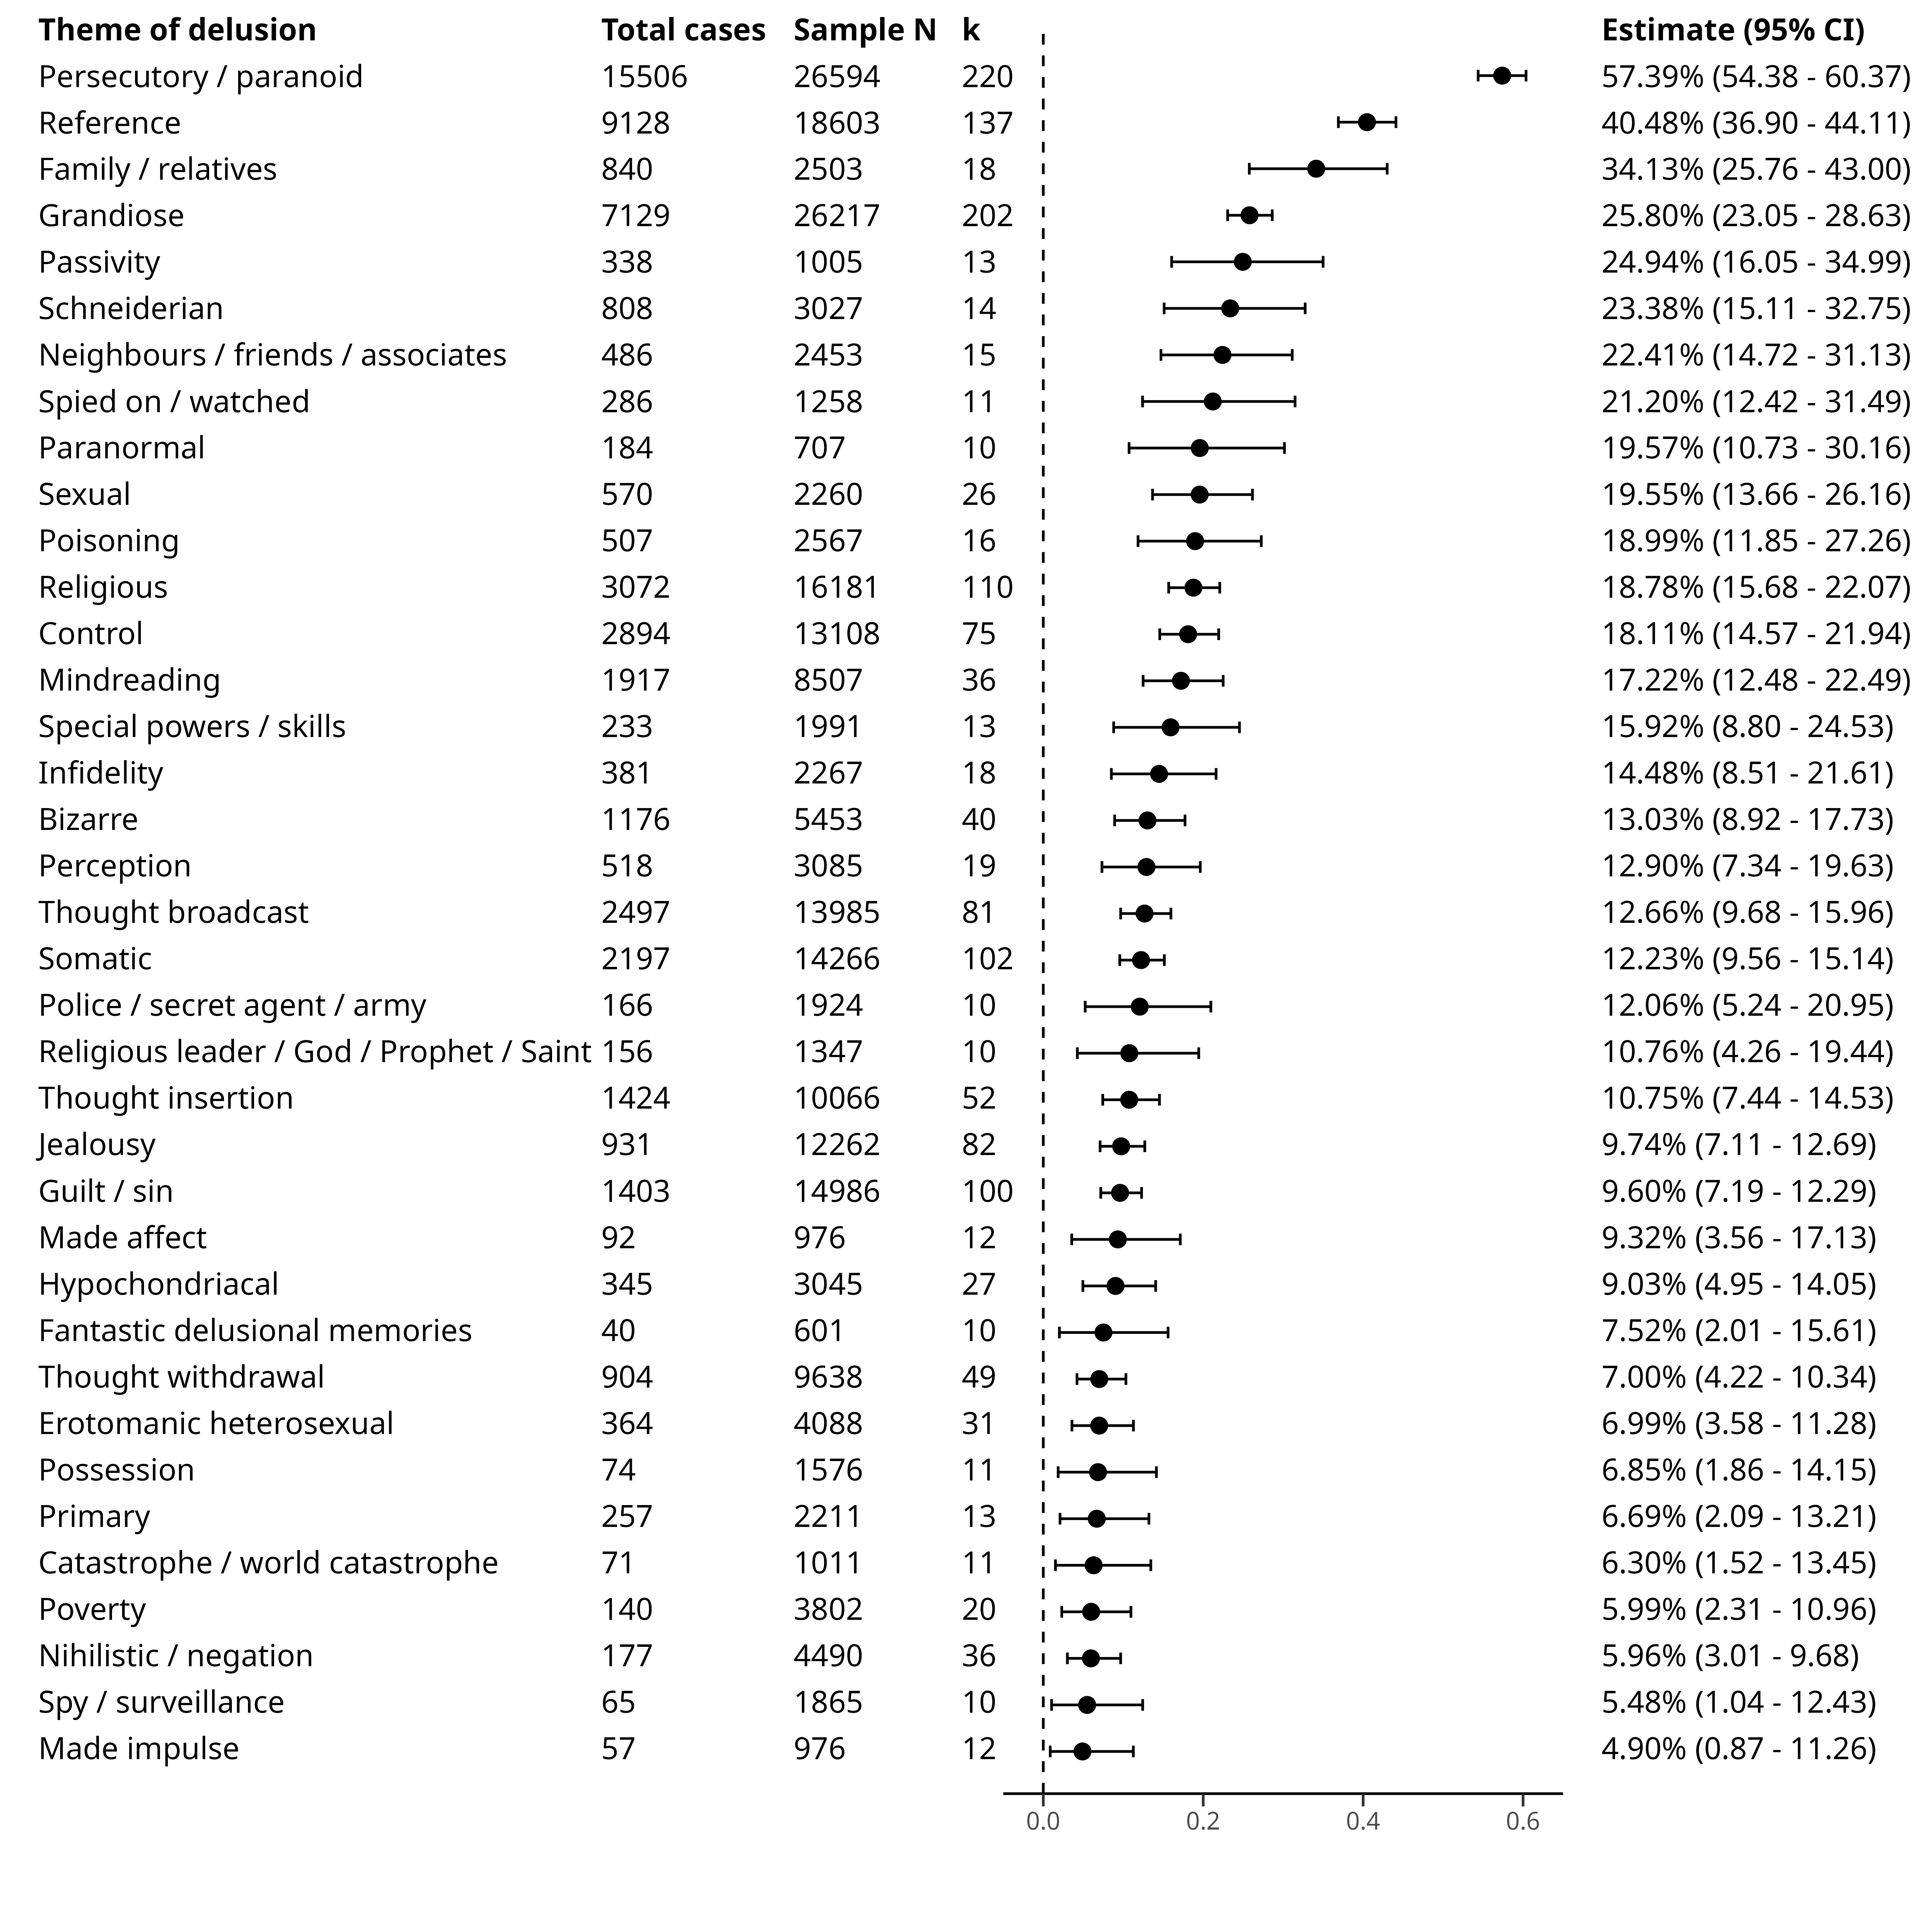

In [12]:
plot <- 1
filename <- paste(output_dir, "figure3_main_forest_plot.png", sep = "")
main_forest_plot <- forester_plot(estimate_df, 0.65, filename)
display_png(file = filename, width = 1000)

### Descriptive statistics

In [13]:
sprintf("Total number of studies selected: %d", length(unique(delus_themes_data$study)))
sprintf("Total number of studies included in meta-analysis: %d", length(unique(delus_themes_data_inclusive_recoded_min_k$study)))
sprintf("Total number of samples in included studies: %d", length(unique(delus_themes_data_inclusive_recoded$study_sample)))
sprintf("Total number of samples included with k>=10 per theme rule: %d", length(unique(delus_themes_data_inclusive_recoded_min_k$study_sample)))
sprintf("Total number of patients included with k>=10 per theme rule: %d", sum(delus_themes_data_inclusive_recoded_min_k$psychotic_n))

[1] "Total number of studies selected: 155"

[1] "Total number of studies included in meta-analysis: 155"

[1] "Total number of samples in included studies: 234"

[1] "Total number of samples included with k>=10 per theme rule: 234"

[1] "Total number of patients included with k>=10 per theme rule: 240901"

In [14]:
# Calculate descriptive statistics 
vars_by_study_sample <- delus_themes_data_inclusive_recoded_min_k %>%
  group_by(study_sample) %>%
  reframe(
    publishedyear = unique(publishedyear),
    percentfemales = unique(percentfemales),
    agemean = unique(agemean),
    psychosisdurationyears = unique(psychosisdurationyears),
    percentantipsychoticmedication = unique(percentantipsychoticmedication),
    country = unique(country),
    diagnosiscoded = unique(diagnosiscoded),
    setting = unique(setting),
    ethnicity = unique(ethnicity),
    globeculturalcluster = unique(globeculturalcluster),
    scale = unique(scale)
  )

# Replace all blanks with NAs
vars_by_study_sample <- vars_by_study_sample %>%
  mutate_all(~replace(., . == "", NA))

# Give vars human readable labels
label(vars_by_study_sample$publishedyear) <- "Published year"
label(vars_by_study_sample$agemean) <- "Age"
label(vars_by_study_sample$percentfemales) <- "% Female"
label(vars_by_study_sample$psychosisdurationyears) <- "Psychosis duration (years)"
label(vars_by_study_sample$percentantipsychoticmedication) <- "% Antipsychotic meds"

# Give vars human readable labels
label(vars_by_study_sample$country) <- "Country"
label(vars_by_study_sample$diagnosiscoded) <- "Diagnosis"
label(vars_by_study_sample$setting) <- "Setting"
label(vars_by_study_sample$ethnicity) <- "Ethnicity"
label(vars_by_study_sample$globeculturalcluster) <- "GLOBE Cluster"
label(vars_by_study_sample$scale) <- "Measurement scale"

In [15]:
# Display nicely formatted table of continuous variable descriptives and save to HTML file
filename <- paste(output_dir, "tableS5.html", sep = "")
continuous_desc_table <- table1(~ publishedyear + agemean + percentfemales + psychosisdurationyears + percentantipsychoticmedication, data = vars_by_study_sample)
t1flex(continuous_desc_table) %>%
  save_as_html(path = filename)
display_html(file = filename)

<!DOCTYPE html>

 

 

 
 
 

 



 





















 

 




 




   Overall (N=234) Published year   Mean (SD) 2000 (14.4)   Median [Min, Max] 2010 [1960, 2020] Age   Mean (SD) 37.7 (8.05)   Median [Min, Max] 37.1 [22.2, 61.0]   Missing 41 (17.5%) % Female   Mean (SD) 0.473 (0.208)   Median [Min, Max] 0.464 [0, 1.00]   Missing 27 (11.5%) Psychosis duration (years)   Mean (SD) 10.5 (5.55)   Median [Min, Max] 10.7 [0.0100, 25.4]   Missing 105 (44.9%) % Antipsychotic meds   Mean (SD) 0.721 (0.372)   Median [Min, Max] 0.904 [0, 1.00]   Missing 190 (81.2%) 



<!-- code folding -->

In [16]:
# Display nicely formatted table of factor variable descriptives and save to HTML file
filename <- paste(output_dir, "tableS4.html", sep = "")
factor_desc_table <- table1(~ country + diagnosiscoded + setting + ethnicity + globeculturalcluster + scale, data = vars_by_study_sample)
t1flex(factor_desc_table) %>%
  save_as_html(path = filename)
display_html(file = filename)

<!DOCTYPE html>

 

 

 
 
 

 



 





















 

 




 




   Overall (N=234) Country   Australia 18 (7.7%)   Austria 1 (0.4%)   Brazil 2 (0.9%)   Canada 7 (3.0%)   China 5 (2.1%)   Denmark 7 (3.0%)   Egypt 3 (1.3%)   France 4 (1.7%)   Germany 10 (4.3%)   Greece 3 (1.3%)   India 23 (9.8%)   Iran 1 (0.4%)   Iraq 2 (0.9%)   Italy 16 (6.8%)   Japan 3 (1.3%)   Kenya 1 (0.4%)   Korea 2 (0.9%)   Lebanon 1 (0.4%)   Lithuania 1 (0.4%)   Malaysia 5 (2.1%)   Micronesia 1 (0.4%)   Multiple 3 (1.3%)   Namibia 1 (0.4%)   Netherlands 3 (1.3%)   Nigeria 1 (0.4%)   Norway 5 (2.1%)   Pakistan 5 (2.1%)   Russia 1 (0.4%)   Saudi Arabia 1 (0.4%)   South Africa 9 (3.8%)   South Korea 2 (0.9%)   Spain 13 (5.6%)   Sri Lanka 1 (0.4%)   Taiwan 1 (0.4%)   Tunisia 1 (0.4%)   Turkey 3 (1.3%)   UK 25 (10.7%)   USA 41 (17.5%)   Missing 2 (0.9%) Diagnosis   Affective Psychosis 4 (1.7%)   Anxiety Disorder 1 (0.4%)   Bipolar Disorder 32 (13.7%)   Body Dysmorphic Disorder 1 (0.4%)   Borderline Personality Disorder 3 (1.3%)   Brief Psychotic Disorder 5 (2.1%)   Delusional Disorder 21 (9.0%)   First Episode Psychosis 10 (4.3%)   Major Depressive Disorder 18 (7.7%)   Mood Disorder 1 (0.4%)   Non-affective Psychosis 1 (0.4%)   OCD 1 (0.4%)   Postpartum Psychosis 2 (0.9%)   Psychosis 44 (18.8%)   PTSD 1 (0.4%)   Schizoaffective Disorder 6 (2.6%)   Schizophrenia 82 (35.0%)   Schizophreniform 1 (0.4%) Setting   Both 44 (18.8%)   Inpatient 143 (61.1%)   Outpatient 40 (17.1%)   Missing 7 (3.0%) Ethnicity   92% Caucasian 1 (0.4%)   African American 2 (0.9%)   American 13 (5.6%)   Australian 16 (6.8%)   Austrian 1 (0.4%)   Azeri 1 (0.4%)   Bantu (Tswana, Zulu, Sotho, and Xhosa) South African 1 (0.4%)   British 7 (3.0%)   Canadian 5 (2.1%)   Chamorro 1 (0.4%)   Chinese 6 (2.6%)   Danish 4 (1.7%)   Dutch 3 (1.3%)   Egyptian 1 (0.4%)   French 3 (1.3%)   German 8 (3.4%)   Global 2 (0.9%)   Greek 3 (1.3%)   Hindu 7 (3.0%)   Iban 1 (0.4%)   Indian 12 (5.1%)   Iraqi 2 (0.9%)   Italian 9 (3.8%)   Jamaican 1 (0.4%)   Japanese 3 (1.3%)   Kenyan 1 (0.4%)   Korean 2 (0.9%)   Korean Chinese 1 (0.4%)   Lebanese 1 (0.4%)   Lithuanian 1 (0.4%)   Malay 2 (0.9%)   Mixed 2 (0.9%)   Mixed American 17 (7.3%)   Mixed Brazilian 2 (0.9%)   Mixed British 8 (3.4%)   Mixed Canadian 1 (0.4%)   Namibian 1 (0.4%)   Nigerian 1 (0.4%)   Norwegian 5 (2.1%)   Pakistani 4 (1.7%)   Pakistani, Indian 2 (0.9%)   Refugee 1 (0.4%)   Saudi Arabian 1 (0.4%)   South African 6 (2.6%)   South Korean 2 (0.9%)   Spanish 11 (4.7%)   Sri Lankan 1 (0.4%)   Taiwanese 1 (0.4%)   Turkish 2 (0.9%)   White American 1 (0.4%)   Xhosa 2 (0.9%)   Missing 42 (17.9%) GLOBE Cluster   Anglo 91 (38.9%)   Confucian Asia 13 (5.6%)   Eastern Europe 4 (1.7%)   Germanic Europe 14 (6.0%)   Latin America 2 (0.9%)   Latin Europe 33 (14.1%)   Middle East 12 (5.1%)   Multiple 3 (1.3%)   Nordic Europe 12 (5.1%)   Other 1 (0.4%)   Southern Asia 34 (14.5%)   Sub-Saharan Africa 6 (2.6%)   Missing 9 (3.8%) Measurement scale   AMDP 4 (1.7%)   AMDP-4 1 (0.4%)   CASH-SAPS 4 (1.7%)   DIGS 6 (2.6%)   DIP 5 (2.1%)   DIS-R 2 (0.9%)   DOAI 1 (0.4%)   FPS 1 (0.4%)   ICD-10 1 (0.4%)   Itil-Keskiner Scale 2 (0.9%)   MADS 6 (2.6%)   MMADS 2 (0.9%)   None used 61 (26.1%)   OPCRIT-PSE 1 (0.4%)   PANSS 2 (0.9%)   PDI 3 (1.3%)   PIQ 3 (1.3%)   PSE 39 (16.7%)   QPE 5 (2.1%)   Questionnaire for psychotic symptoms with a sexual content 1 (0.4%)   RPMIP 2 (0.9%)   SADS 5 (2.1%)   SAPS 31 (13.2%)   SCAAPS 1 (0.4%)   SCAN 1 (0.4%)   SCAN-PSE 1 (0.4%)   SCID 25 (10.7%)   SCID-I 6 (2.6%)   SCID-I/P 2 (0.9%)   SCID-IV 2 (0.9%)   SCID-P 7 (3.0%)   Missing 1 (0.4%) 



<!-- code folding -->

In [17]:
country_counts <- vars_by_study_sample %>%
  group_by(country) %>%
  summarize(count = n())

# Create string for each country with its count
country_strings <- paste(country_counts$country, " ", "(k=", country_counts$count, ")", collapse = ", ", sep = "")
country_strings <- sub("NA", "Missing", country_strings)

# Print the final string
print(paste("Studies were conducted in", country_strings))

[1] "Studies were conducted in Australia (k=18), Austria (k=1), Brazil  (k=2), Canada (k=7), China (k=5), Denmark (k=7), Egypt (k=3), France (k=4), Germany (k=10), Greece (k=3), India (k=23), Iran (k=1), Iraq (k=2), Italy (k=16), Japan (k=3), Kenya (k=1), Korea (k=2), Lebanon (k=1), Lithuania (k=1), Malaysia (k=5), Micronesia (k=1), Multiple (k=3), Namibia (k=1), Netherlands (k=3), Nigeria (k=1), Norway (k=5), Pakistan (k=5), Russia (k=1), Saudi Arabia (k=1), South Africa (k=9), South Korea (k=2), Spain (k=13), Sri Lanka  (k=1), Taiwan (k=1), Tunisia (k=1), Turkey (k=3), UK (k=25), USA (k=41), Missing (k=2)"


### Heterogeneity metrics of the main meta-analysis in meta_model

In [18]:
# Get I2 heterogeneity estimates from model
I2_main <- var.comp(meta_model)

# Within study I2 (Level 2)
I2_lvl2_main <- I2_main$results$I2[2]
print(paste("Within study I2 (Level 2):", I2_lvl2_main))

# Between study I2 (Level 3)
I2_lvl3_main <- I2_main$results$I2[3]
print(paste("Between study I2 (Level 3):", I2_lvl3_main))

# Cochran's Q
CochranQ_main <- meta_model$QE
print(paste("Cochran Q:", CochranQ_main))

# Between-study variance (equivalent to tau2 in standard random effect meta-analysis)
sigma2_1_main <- meta_model$sigma2[1]
print(paste("Between-study sigma variance:", sigma2_1_main))

# Within-study variance (as above)
sigma2_2_main <- meta_model$sigma2[2]
print(paste("Within-study sigma variance:", sigma2_2_main))

[1] "Within study I2 (Level 2): 66.94"
[1] "Between study I2 (Level 3): 29.42"
[1] "Cochran Q: 43183.4818200526"
[1] "Between-study sigma variance: 0.0139852196610972"
[1] "Within-study sigma variance: 0.0318155806053043"


### Publication bias

Funnel plot using Henmi and Copas method
https://wviechtb.github.io/metafor/reference/hc.html

png 
  2

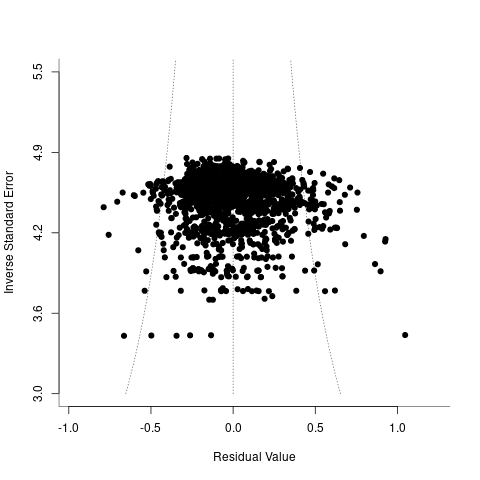

In [19]:
filename <- paste(output_dir, "figureS5_funnel.png", sep = "")
png(filename)
funnel(meta_model, yaxis = "seinv", refline = 0, steps = 5, ylim = c(3,5.5), digits = 1, back="white")
dev.off()
display_png(file = filename, width = 500)

Egger's sandwich test https://europepmc.org/article/MED/32673040

In [20]:
V_mat_egger <- with(ef_calc, impute_covariance_matrix(yi, cluster = study, r = 0.5))
test.egger = rma.mv(yi, V_mat_egger, 
                    random = ~ 1 | study_sample / es_id,
                    sparse = TRUE,
                    data = ef_calc)
print(test.egger)
coef_test(test.egger, vcov = "CR2")


Multivariate Meta-Analysis Model (k = 1672; method: REML)

Variance Components:

            estim    sqrt  nlvls  fixed              factor 
sigma^2.1  0.0000  0.0000    234     no        study_sample 
sigma^2.2  0.0000  0.0000   1672     no  study_sample/es_id 

Test for Heterogeneity:
Q(df = 1671) = 239.0155, p-val = 1.0000

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub    
 -0.0182  0.0221  -0.8223  0.4109  -0.0614  0.0251    

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



Coef    beta        SE        tstat     df_Satt  p_Satt   
intrcpt intrcpt -0.01815603 0.0115594 -1.570673 78.73456 0.1202689

Fernández-Castilla three-level funnel plot test
https://www.tandfonline.com/doi/full/10.1080/00220973.2019.1582470


In [21]:
funnel <- rma.mv(yi, V_mat, mods = psychotic_n, random = ~ 1 | study_sample / es_id, data = ef_calc)
print(funnel)


Multivariate Meta-Analysis Model (k = 1672; method: REML)

Variance Components:

            estim    sqrt  nlvls  fixed              factor 
sigma^2.1  0.0131  0.1145    234     no        study_sample 
sigma^2.2  0.0658  0.2566   1672     no  study_sample/es_id 

Test for Residual Heterogeneity:
QE(df = 1670) = 106013.6227, p-val < .0001

Test of Moderators (coefficient 2):
QM(df = 1) = 0.4677, p-val = 0.4940

Model Results:

         estimate      se     zval    pval    ci.lb   ci.ub      
intrcpt    0.5101  0.0137  37.1297  <.0001   0.4831  0.5370  *** 
mods      -0.0000  0.0001  -0.6839  0.4940  -0.0002  0.0001      

---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



### Tests of Moderators

In [22]:
show_sig_associations <- function(meta_object, moderator, lambda = 0.5) {
  meta_model_coefs <- coef(summary(meta_object))
  
  meta_model_coefs <- meta_model_coefs %>%
    rownames_to_column(var = "row_label")

  meta_model_coefs <- meta_model_coefs %>%
    filter(grepl(":", row_label))
  
  # Calculate false discovery rate (FDR) controlled comparison as Storey (2003) q-value
  meta_model_coefs$qval <- Qvalue(meta_model_coefs$pval, lambda = lambda, silent = TRUE)$qValues
 
  meta_model_coefs_extracted <- meta_model_coefs %>%
    filter(qval < 0.1) %>%
    filter(grepl(moderator, row_label)) %>%
    arrange(desc(row_label))

  meta_model_coefs_extracted <- meta_model_coefs_extracted %>%
    mutate(result_string = sprintf("%s = %.2f [95%% CI %.2f – %.2f]; p = %.4f; q = %.4f)",
                                   row_label, estimate, ci.lb, ci.ub, pval, qval))
  
  if (nrow(meta_model_coefs_extracted) == 0) {
    str = paste("No significant interaction with", moderator, "detected")
    print(str)
  }
  else {
    print("Significant interactions:")
    print("")
    print(meta_model_coefs_extracted$result_string, sep = "\n")
  }
}

In [23]:
# Ensure all blanks in dataframe have NAs so they are correctly recognised by moderator regressions
ef_calc <- ef_calc %>%
  mutate_all(~ifelse(. == "", NA, .))

Effect of quality assessment

In [24]:
meta_model_qual <- rma.mv(yi = yi, V = V_mat,
                          slab = study,
                          random = ~ 1 | study_sample / es_id,
                          mods = ~ qa * theme,
                          method = "REML",
                          level = 95,
                          digits = 3,
                          sparse = TRUE,
                          data = ef_calc)

# Note here, and only here, we use an adjusted lambda value of 0.4 rather than 0.05 to account for the narrow range of p values
show_sig_associations(meta_model_qual, "qa", lambda = 0.4)


Loading required package: qvalue



[1] "No significant interaction with qa detected"


Effect of publication year

In [25]:
meta_model_yr <- rma.mv(yi = yi, V = V_mat,
                        slab = study,
                        random = ~ 1 | study_sample / es_id,
                        mods = ~ publishedyear * theme,
                        method = "REML",
                        level = 95,
                        digits = 3,
                        sparse = TRUE,
                        data = ef_calc)

show_sig_associations(meta_model_yr, "publishedyear")

[1] "Significant interactions:"
[1] ""
[1] "publishedyear:themeprimary = 0.02 [95% CI 0.01 – 0.04]; p = 0.0009; q = 0.0165)"


Effect of mean age

In [26]:
meta_model_age <- rma.mv(yi = yi, V = V_mat,
                         slab = study,
                         random = ~ 1 | study_sample / es_id,
                         mods = ~ agemean * theme,
                         method = "REML",
                         level = 95,
                         digits = 3,
                         sparse = TRUE,
                         data = ef_calc)

show_sig_associations(meta_model_age, "agemean")

Warning message:
“210 rows with NAs omitted from model fitting.”


[1] "No significant interaction with agemean detected"


Effect of percentage of females

In [27]:
meta_model_sex <- rma.mv(yi = yi, V = V_mat,
                         slab = study,
                         random = ~ 1 | study_sample / es_id,
                         mods = ~ percentfemales * theme,
                         method = "REML",
                         level = 95,
                         digits = 3,
                         sparse = TRUE,
                         data = ef_calc)

show_sig_associations(meta_model_sex, "percentfemales")

Warning message:
“125 rows with NAs omitted from model fitting.”


[1] "No significant interaction with percentfemales detected"


Effect of mean psychosis duration in years

In [28]:
meta_model_psychosisdur <- rma.mv(yi = yi, V = V_mat,
                                  slab = study_sample,
                                  random = ~ 1 | study / es_id,
                                  mods = ~ psychosisdurationyears * theme,
                                  method = "REML",
                                  level = 95,
                                  digits = 3,
                                  sparse = TRUE,
                                  data = ef_calc)

show_sig_associations(meta_model_psychosisdur, "psychosisdurationyears")

Warning message:
“672 rows with NAs omitted from model fitting.”


[1] "No significant interaction with psychosisdurationyears detected"


Effect of proportion on antipsychotic medication 

In [29]:
meta_model_psychosisdur <- rma.mv(yi = yi, V = V_mat,
                                  slab = study_sample,
                                  random = ~ 1 | study / es_id,
                                  mods = ~ percentantipsychoticmedication * theme,
                                  method = "REML",
                                  level = 95,
                                  digits = 3,
                                  sparse = TRUE,
                                  data = ef_calc)

show_sig_associations(meta_model_psychosisdur, "percentantipsychoticmedication")

Warning message:
“1401 rows with NAs omitted from model fitting.”
Warning message:
“Redundant predictors dropped from the model.”


[1] "No significant interaction with percentantipsychoticmedication detected"


Effect of diagnosis

In [30]:
# Ensure diagnosis coded as a factor variable and reference level to Schizophrenia
ef_calc$diagnosiscoded <- factor(ef_calc$diagnosiscoded)
ef_calc$diagnosiscoded <- relevel(ef_calc$diagnosiscoded, ref = "Psychosis")

meta_model_dx <- rma.mv(yi = yi, V = V_mat,
                        slab = study,
                        random = ~ 1 | study_sample / es_id,
                        mods = ~ diagnosiscoded * theme,
                        method = "REML",
                        level = 95,
                        digits = 3,
                        sparse = TRUE,
                        data = ef_calc)

show_sig_associations(meta_model_dx, "diagnosiscoded")

Warning message:
“Redundant predictors dropped from the model.”


[1] "Significant interactions:"
[1] ""
[1] "diagnosiscodedFirst Episode Psychosis:themereference = 0.32 [95% CI 0.12 – 0.52]; p = 0.0016; q = 0.0998)"           
[2] "diagnosiscodedFirst Episode Psychosis:themepersecutory_paranoid = 0.30 [95% CI 0.11 – 0.50]; p = 0.0023; q = 0.0998)"
[3] "diagnosiscodedDelusional Disorder:themejealousy = 0.27 [95% CI 0.10 – 0.44]; p = 0.0022; q = 0.0998)"                
[4] "diagnosiscodedDelusional Disorder:themegrandiose = -0.28 [95% CI -0.43 – -0.12]; p = 0.0004; q = 0.0686)"            


Effect of mood disorder

In [31]:
# Ensure coded as a factor variable and reference level to no
ef_calc$mooddisordercoded <- as.factor(ef_calc$mooddisordercoded)
ef_calc$mooddisordercoded <- relevel(ef_calc$mooddisordercoded, ref = "no")

meta_model_mood <- rma.mv(yi = yi, V = V_mat,
                          slab = study,
                          random = ~ 1 | study_sample / es_id,
                          mods = ~ mooddisordercoded * theme,
                          method = "REML",
                          level = 95,
                          digits = 3,
                          sparse = TRUE,
                          data = ef_calc)

show_sig_associations(meta_model_mood, "mooddisordercoded")

Warning message:
“Redundant predictors dropped from the model.”


[1] "No significant interaction with mooddisordercoded detected"


Effect of setting (Inpatient, Outpatient, Both)

In [32]:
# Ensure coded as a factor variable and reference level to Inpatient
ef_calc$setting <- as.factor(ef_calc$setting)
ef_calc$setting <- relevel(ef_calc$setting, ref = "Inpatient")

meta_model_setting <- rma.mv(yi = yi, V = V_mat,
                             slab = study_sample,
                             random = ~ 1 | study / es_id,
                             mods = ~ setting * theme,
                             method = "REML",
                             level = 95,
                             digits = 3,
                             sparse = TRUE,
                             data = ef_calc)

show_sig_associations(meta_model_setting, "setting")

Warning message:
“31 rows with NAs omitted from model fitting.”
Warning message:
“Redundant predictors dropped from the model.”


[1] "No significant interaction with setting detected"


Effect of continent 

In [33]:
# Ensure coded as a factor variable and reference level to North America
ef_calc$continent <- as.factor(ef_calc$continent)
ef_calc$continent <- relevel(ef_calc$continent, ref = "North America")

meta_model_cont <- rma.mv(yi = yi, V = V_mat,
                          slab = study_sample,
                          random = ~ 1 | study / es_id,
                          mods = ~ continent * theme,
                          method = "REML",
                          level = 95,
                          digits = 3,
                          sparse = TRUE,
                          data = ef_calc)

show_sig_associations(meta_model_cont, "continent")

Warning message:
“24 rows with NAs omitted from model fitting.”
Warning message:
“Redundant predictors dropped from the model.”


[1] "Significant interactions:"
[1] ""
[1] "continentEurope:themeperception = -0.58 [95% CI -0.95 – -0.21]; p = 0.0020; q = 0.0983)"
[2] "continentEurope:themegrandiose = -0.25 [95% CI -0.41 – -0.09]; p = 0.0022; q = 0.0983)" 


Effect of GLOBE cultural cluster 

In [34]:
# Ensure coded as a factor variable and reference level to Anglo
ef_calc$globeculturalcluster <- as.factor(ef_calc$globeculturalcluster)
ef_calc$globeculturalcluster <- relevel(ef_calc$globeculturalcluster, ref = "Anglo")

meta_model_cult <- rma.mv(yi = yi, V = V_mat,
                          slab = study_sample,
                          random = ~ 1 | study / es_id,
                          mods = ~ globeculturalcluster * theme,
                          method = "REML",
                          level = 95,
                          digits = 3,
                          sparse = TRUE,
                          data = ef_calc)

show_sig_associations(meta_model_cult, "globeculturalcluster")

Warning message:
“58 rows with NAs omitted from model fitting.”
Warning message:
“Redundant predictors dropped from the model.”


[1] "Significant interactions:"
[1] ""
[1] "globeculturalclusterSouthern Asia:themejealousy = 0.30 [95% CI 0.12 – 0.48]; p = 0.0013; q = 0.0776)"             
[2] "globeculturalclusterMiddle East:themesexual = 1.24 [95% CI 0.65 – 1.83]; p = 0.0000; q = 0.0048)"                 
[3] "globeculturalclusterMiddle East:themejealousy = 0.73 [95% CI 0.25 – 1.20]; p = 0.0028; q = 0.0782)"               
[4] "globeculturalclusterEastern Europe:themeguilt/sin = 0.45 [95% CI 0.15 – 0.76]; p = 0.0038; q = 0.0782)"           
[5] "globeculturalclusterConfucian Asia:themepersecutory_paranoid = 0.54 [95% CI 0.18 – 0.89]; p = 0.0032; q = 0.0782)"
[6] "globeculturalclusterConfucian Asia:themeperception = 0.67 [95% CI 0.22 – 1.11]; p = 0.0031; q = 0.0782)"          


### Sensitivity and influence diagnostics

In [35]:
#
# Function to see if a new version of meta-analysis has altered any theme estimates so the
# estimate is outside pre-existing CIs of original meta-analysis in estimate_df
#
check_if_estimates_altered_outside_prev_CIs <- function(new_df) {
  outside_CIs <- FALSE
  themes_list <- as.list(new_df$theme)

  # Iterate through themes and if estimate of prevalence of a theme in new_df fall outside of the 95% CIs of estimate in estimate_df
  # ...put a 1 into a variable called outside_CIs, otherwise put 0
  for (theme in themes_list) {
    new_theme_prev <- new_df$prevalence[new_df$theme == theme]
    if (new_theme_prev > estimate_df$ci.ub[estimate_df$theme == theme] | new_theme_prev < estimate_df$ci.lb[estimate_df$theme == theme]) {
      new_df$outside_CIs[new_df$theme == theme] <- 1
    } else {
      new_df$outside_CIs[new_df$theme == theme] <- 0
    }
  }
  
  # Iterate through and print whether each theme has a substantially new estimate on the adjusted dataset
  for (i in 1:nrow(new_df)) {
    if (new_df$outside_CIs[i] == 1) {
      print(sprintf("* The newly estimated prevalence for theme %s is outside the previously estimates CIs", new_df$theme[i]))
      outside_CIs <- TRUE
    }
  }
  return(outside_CIs)
}

#### Leave one out sensitivity diagnostics 

metafor function leave1out doesn't work on multi-level rma.mv models, so this is a manual version. Runs in parallel to speed it up.

In [36]:
# Get list of studies and their number
study_list <- unique(delus_themes_data_inclusive_recoded_min_k$study)
study_count <- length(study_list)

Set up parelling processing

In [37]:
# Set up parallel processing as we can assign each meta-analysis to a separate core
# to speed up calculation, leaving one core free for system processing
n_cores <- detectCores() - 1
cl <- makeCluster(n_cores)
registerDoParallel(core = n_cores)

Run leave one out analysis and store results dataframes in a list called l1o_results

In [38]:
# Iterate through studies, removing each study from dataset and re-run meta-analysis
# Results get stored in l1o_result which is a list of results dataframes
l1o_results <- foreach(i = 1:study_count) %dopar% {
  l1o_delus_themes_data <- delus_themes_data_inclusive_recoded_min_k %>%
    filter(study != study_list[i])
  study_list[i]
  run_meta(l1o_delus_themes_data, sparse_option = FALSE)
}

Iterate through the leave1out results dataframes and indicate if any of the new prevalence estimates fall outside confidence intervals of estimates from the meta-analysis where all studies were included (estimate_df dataframe). Print any we find.

In [39]:
for (i in 1:study_count) {
  # Check for changed estimate of prevalence outside previous CIs and put a 1 in 'altered' column if so
  if (check_if_estimates_altered_outside_prev_CIs(l1o_results[[i]]) == TRUE) {
    print(paste("...after removal of: ", study_list[i], sep = ""))
  }
}

# Free memory
rm(l1o_results)

None identified

In [40]:
l1o_est_altered_outliers <- c()

Re-run leave1out analysis. This time storing meta-analysis models in the list l1o_models so we can extract study heterogeneity stats


In [41]:
l1o_models <- foreach(i = 1:study_count) %dopar% {
  l1o_delus_themes_data <- delus_themes_data_inclusive_recoded_min_k %>%
    filter(study != study_list[i])
  study_list[i]
  run_meta(l1o_delus_themes_data, sparse_option = FALSE)
  meta_model
}  

Extract I2_lvl3 between study heterogeneity statistics

In [42]:
I2_lvl3_vec <- c()

for (i in 1:study_count) {
  I2_main <- var.comp(l1o_models[[i]])
  I2_lvl3_vec[i] <- as.double(I2_main$results$I2[3])
}

I2_lvl3_vec <- setNames(I2_lvl3_vec, study_list)

# Free memory
rm(l1o_models)

Plot it to identify outliers that increase between-study heterogeneity

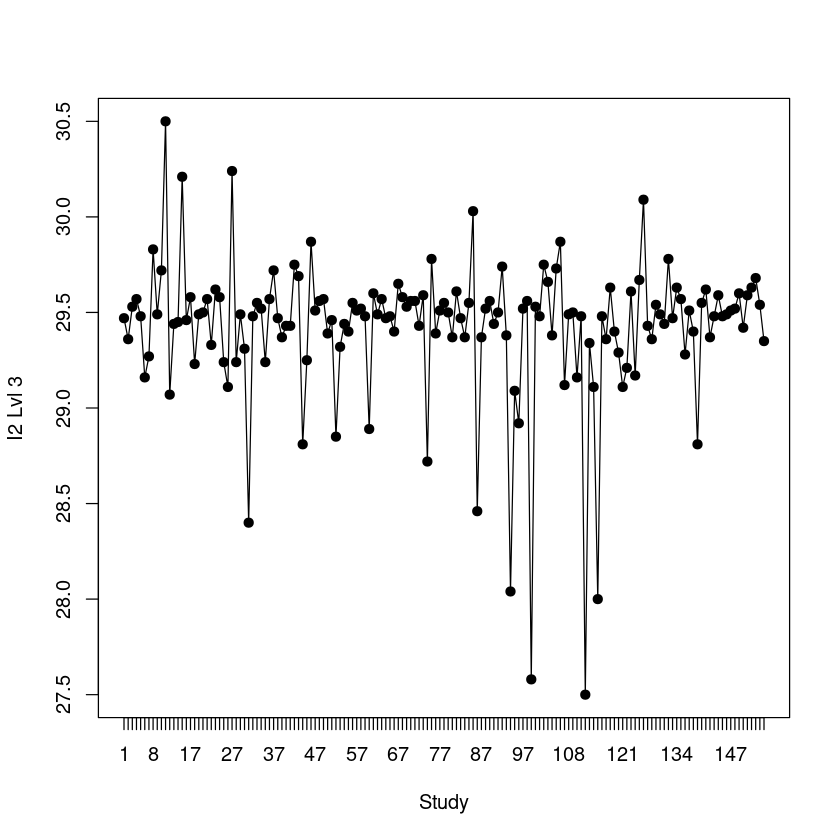

In [43]:
plot(I2_lvl3_vec, type = "o", pch = 19, xlab = "Study", ylab = "I2 Lvl 3", xaxt = "n")
axis(side = 1, at = seq_along(I2_lvl3_vec), labels = seq_along(I2_lvl3_vec))

Add identified outliers to our outlier list

In [44]:
i2_outliers <- names(I2_lvl3_vec[I2_lvl3_vec > 30.25])
i2_outliers

[1] "Bambole 2013"

#### DFBETAS for influential study detection

Calculate DF Betas, using parallel processing option. n_cores defined in 'Leave one out sensitivity diagnostics' section

In [45]:
dfbetas <- dfbetas(meta_model, cluster = study, parallel = "snow", ncpus = n_cores, reestimate = FALSE)

Identify outliers

Warning message in as.graphicsAnnot(labels):
“NAs introduced by coercion”


[1] "No influential studies identifed by analysis of DF Betas"


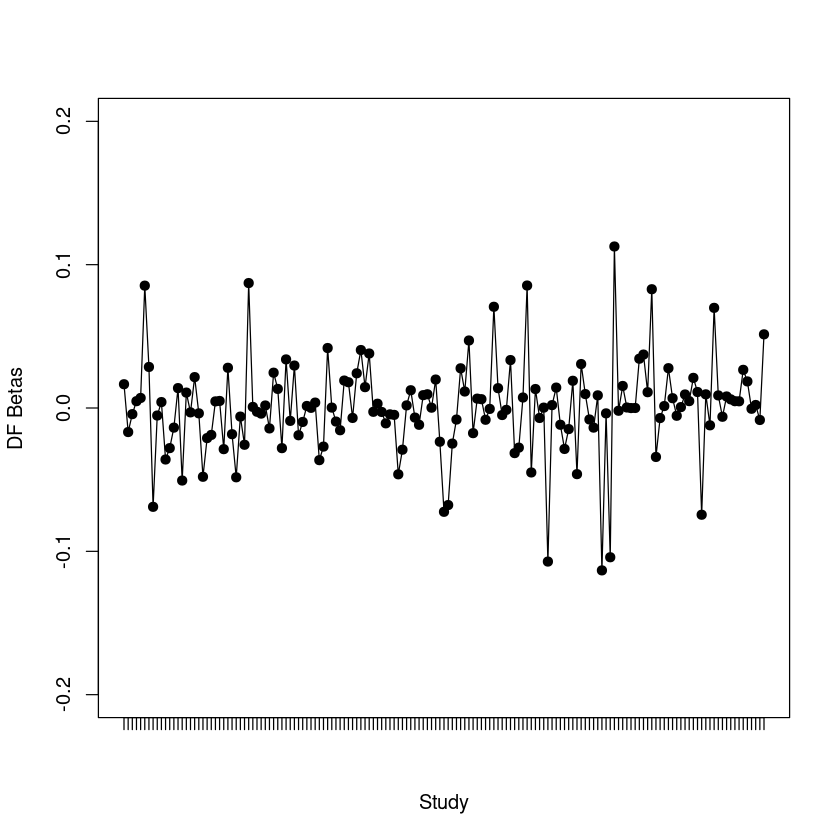

In [46]:
# Calculate mean DF Betas for studies
dfbetas_new <- dfbetas %>%
  mutate(mean_of_all_columns = rowMeans(select(., everything()))) 

# Convert into vector
mean_df_betas <- as.vector(dfbetas_new$mean_of_all_columns)
names(mean_df_betas) <- rownames(dfbetas_new)

# Identify outliers based on standard formula of 2/sqrt(k)
df_beta_cutoff <- 2/sqrt(length(mean_df_betas))
df_betas_outliers <- mean_df_betas[mean_df_betas > df_beta_cutoff]

if (length(df_betas_outliers) > 0) {
  # Plot and label any outliers
  plot(mean_df_betas, type = "o", pch = 19, ylim = c(-0.2, 0.2), xlab = "Study", ylab = "DF Betas", xaxt = "n")
  axis(side = 1, at = seq_along(mean_df_betas), labels = as.numeric(names(mean_df_betas)))
  text(which(mean_df_betas > df_beta_cutoff), df_outliers, labels = names(df_betas_outliers), pos = 3)
} else {
  plot(mean_df_betas, type = "o", pch = 19, ylim = c(-0.2, 0.2), xlab = "Study", ylab = "DF Betas", xaxt = "n")
  axis(side = 1, at = seq_along(mean_df_betas), labels = as.numeric(names(mean_df_betas)))
  print("No influential studies identifed by analysis of DF Betas")
}

Cook's distances for influential study detection

Calculate Cook's distances, using parallel processing option. n_cores defined in 'Leave one out sensitivity diagnostics' section

In [47]:
c_distances <- cooks.distance(meta_model, cluster = study, parallel = "snow", ncpus = n_cores, progbar = TRUE, reestimate = FALSE)

Identify studies with anomalous Cook's distance using Fox J (2019). Regression diagnostics.

Warning message in as.graphicsAnnot(labels):
“NAs introduced by coercion”


[1] "Azhar 1995" "Kim 1993"   "Kim 2001"   "Toh 2016"

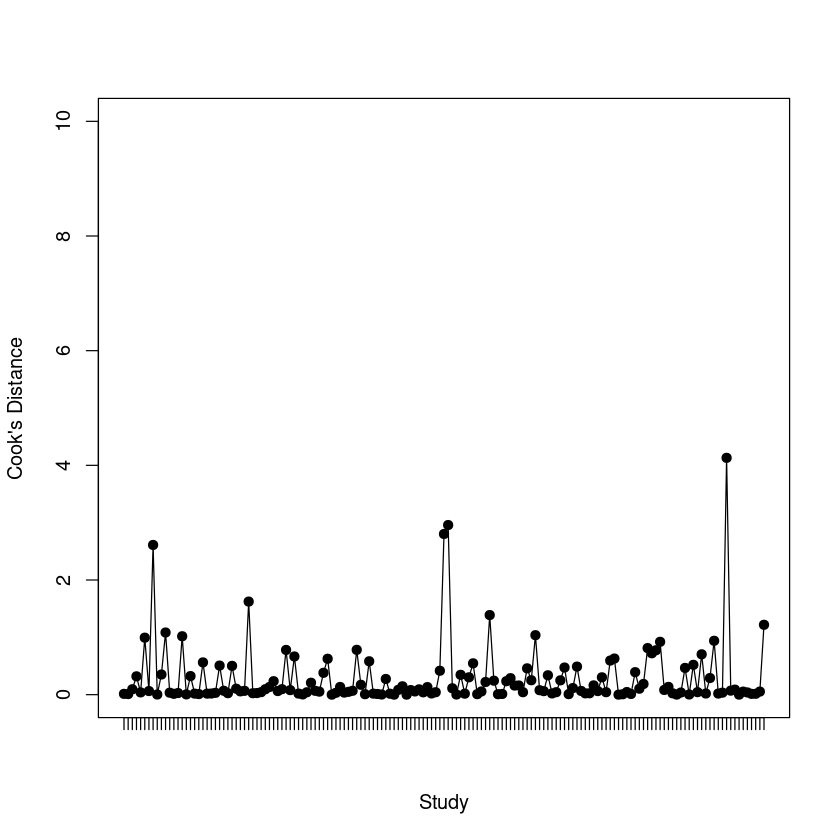

In [48]:
# Plot Cook's distances by study
plot(c_distances, type = "o", pch = 19, ylim = c(0, 10), xlab = "Study", ylab = "Cook's Distance", xaxt = "n")
axis(side = 1, at = seq_along(c_distances), labels = as.numeric(names(c_distances)))

cd_outliers <- names(c_distances[c_distances > 2])
cd_outliers

Hat values for influential study detection

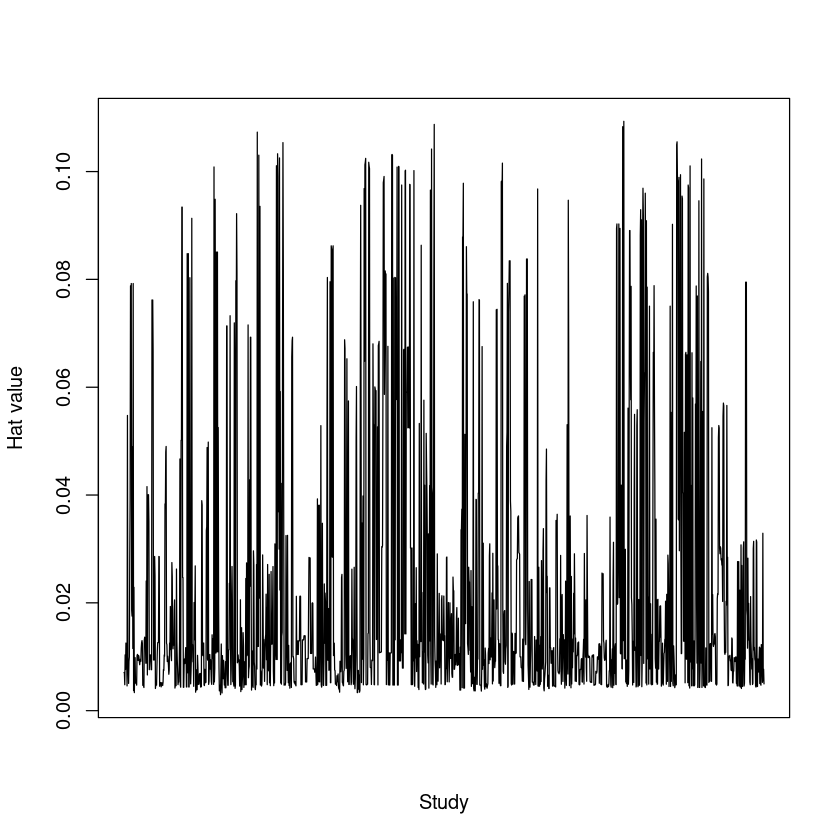

In [49]:
hatvalues <- hatvalues(meta_model, type = "diagonal")
plot(hatvalues, type = "l", xaxt = "n", xlab = "Study", ylab = "Hat value")
# None detected
hat_outliers <- c()

#### Sensitivity analysis (i.e. re-run meta-analyis) with influential studies removed

Create combined list of outliers and use the list to remove these influential studies from the dataset

In [50]:
inf_study_list <- c(l1o_est_altered_outliers, cd_outliers, i2_outliers, hat_outliers)
inf_study_list <- unique(inf_study_list)
inf_study_list

delus_themes_data_minus_inf <- delus_themes_data_inclusive_recoded_min_k %>%
  filter(!(study %in% inf_study_list))

[1] "Azhar 1995"   "Kim 1993"     "Kim 2001"     "Toh 2016"     "Bambole 2013"

Re-run meta-analysis with these studies removed

In [51]:
minus_inf_estimate_df <- run_meta(delus_themes_data_minus_inf, sparse_option = FALSE)

Check if this changes any of the estimates outside original CIs

In [52]:
check_if_estimates_altered_outside_prev_CIs(minus_inf_estimate_df)

[1] FALSE

Replot the forest plot

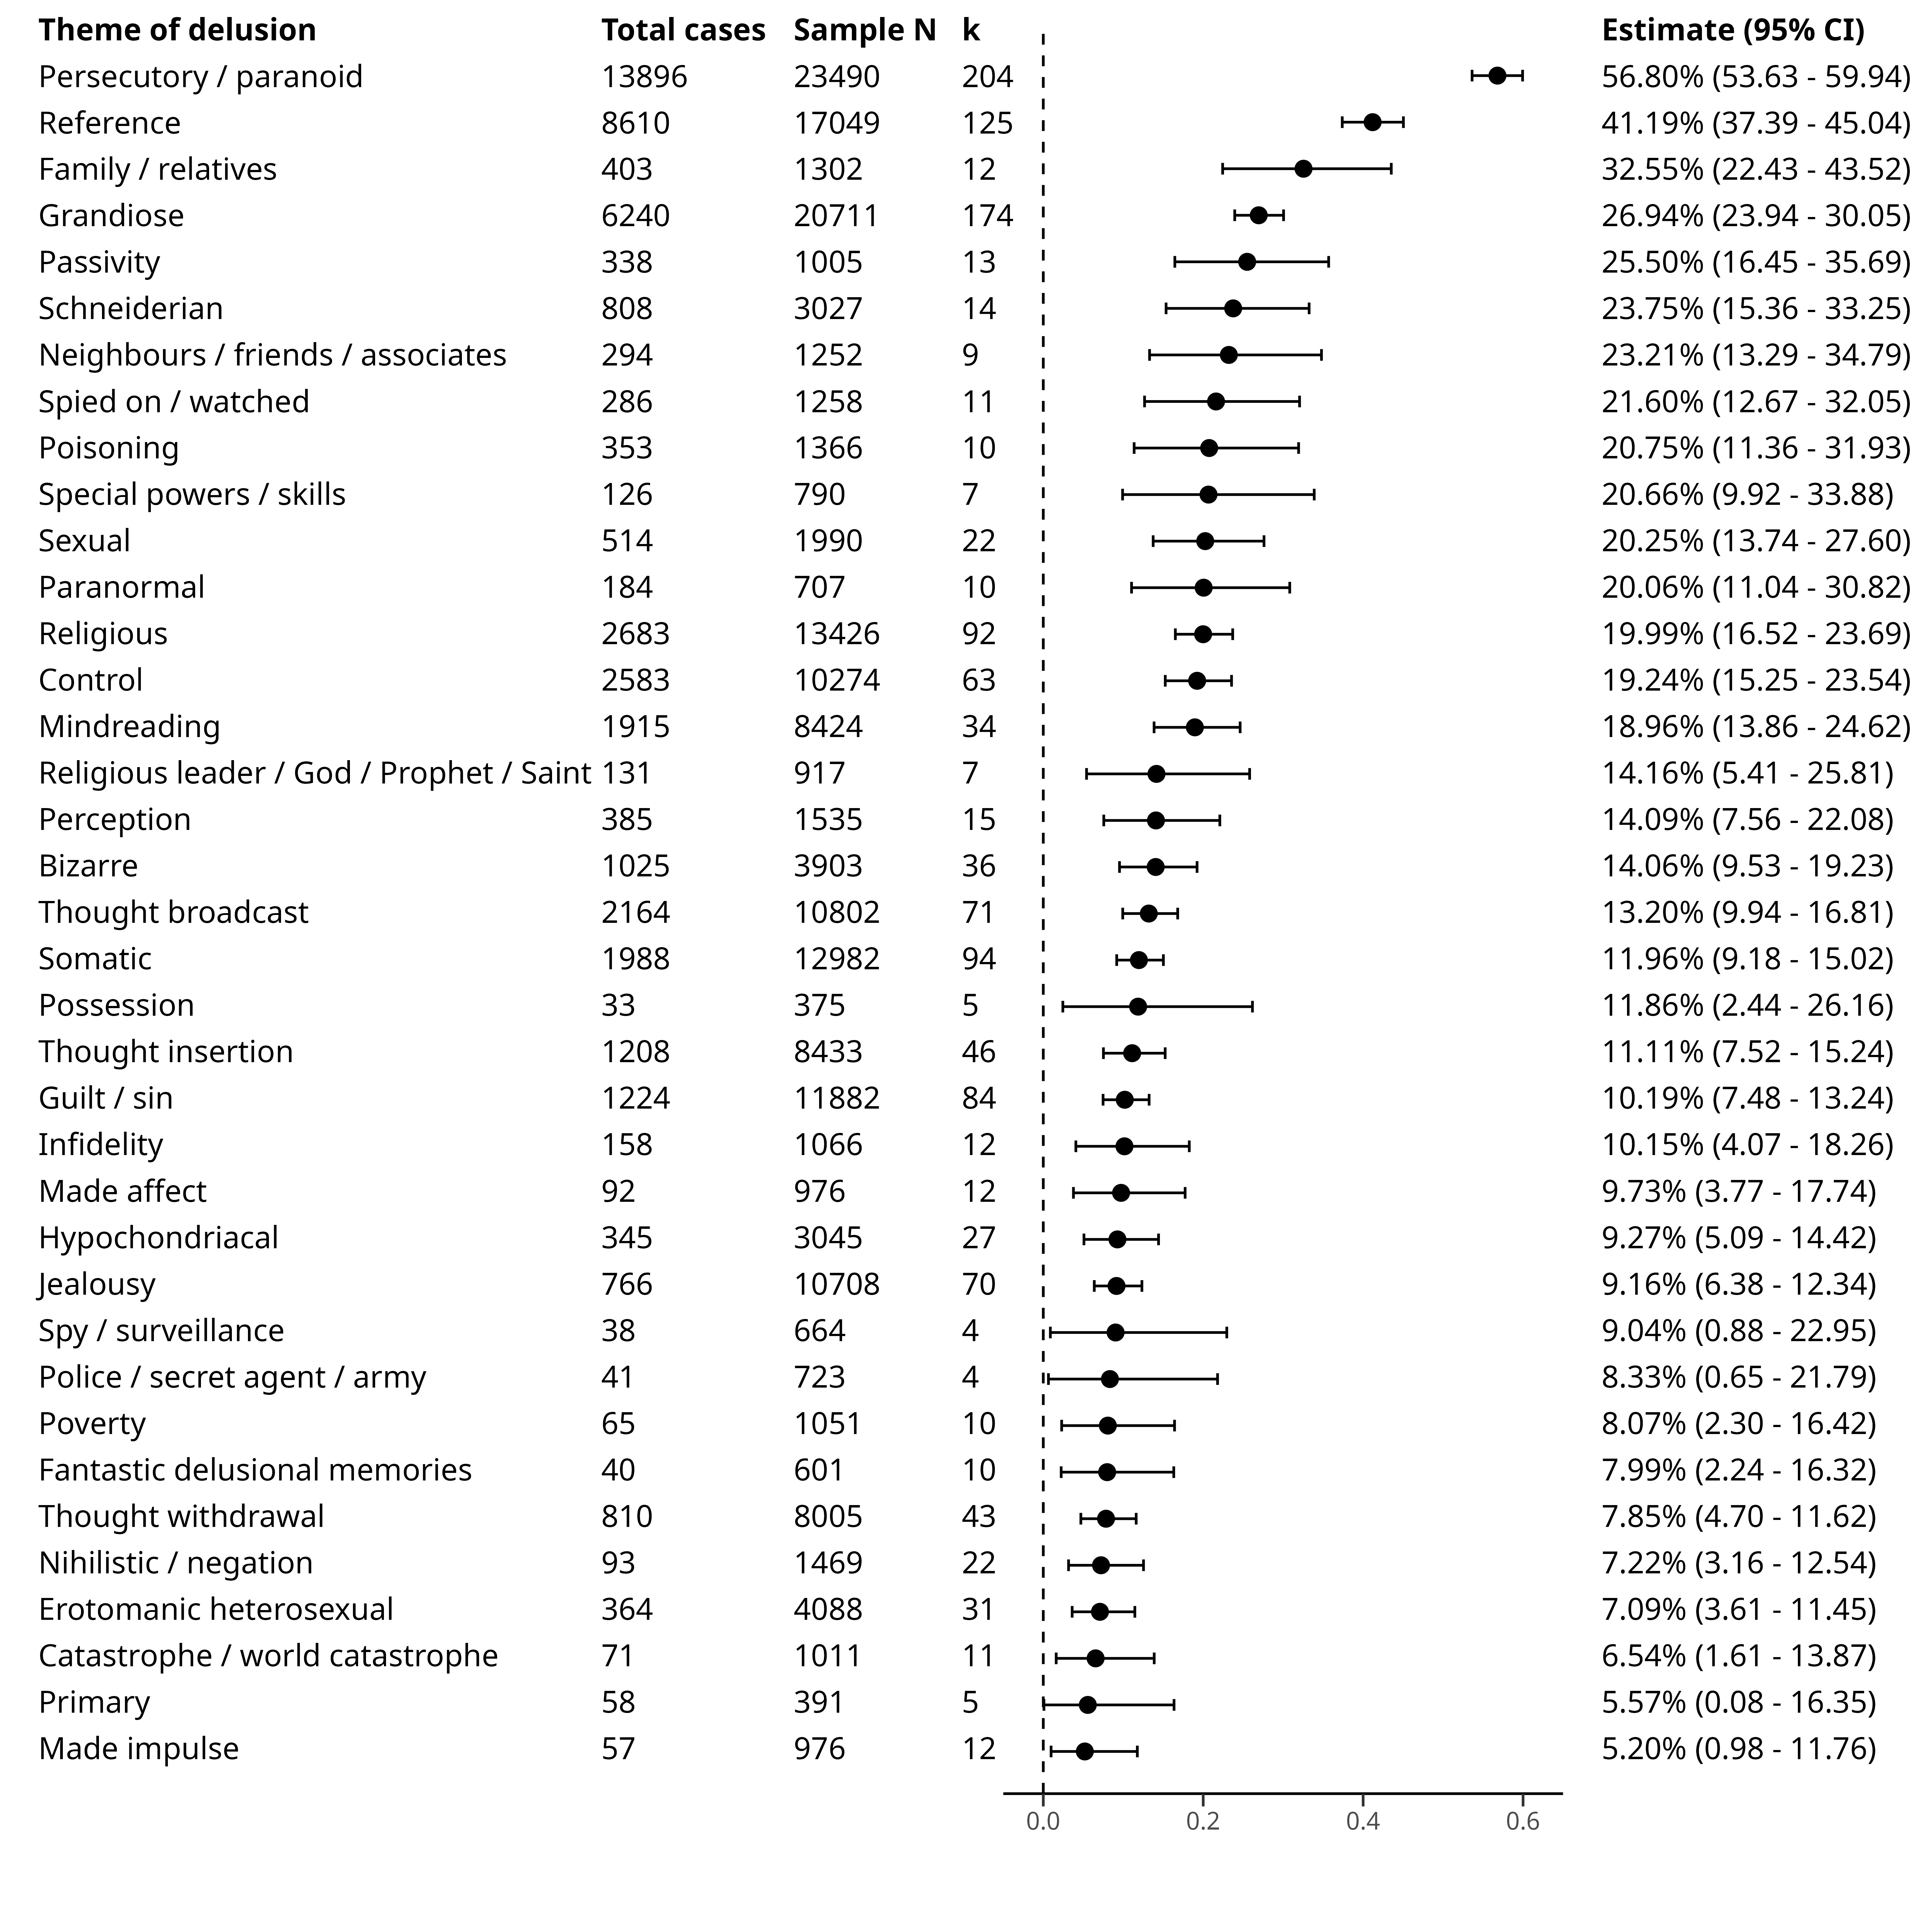

In [53]:
filename <- paste(output_dir, "figureS6_minus_inf_forest_plot.png", sep = "")
forester_plot(minus_inf_estimate_df, max_ci_ub = 0.65, filename)
display_png(file = filename, width = 1000)

#### Sensitivity analysis for alternative rho values

Sensitivity analysis with rho = 0.3

[1] FALSE

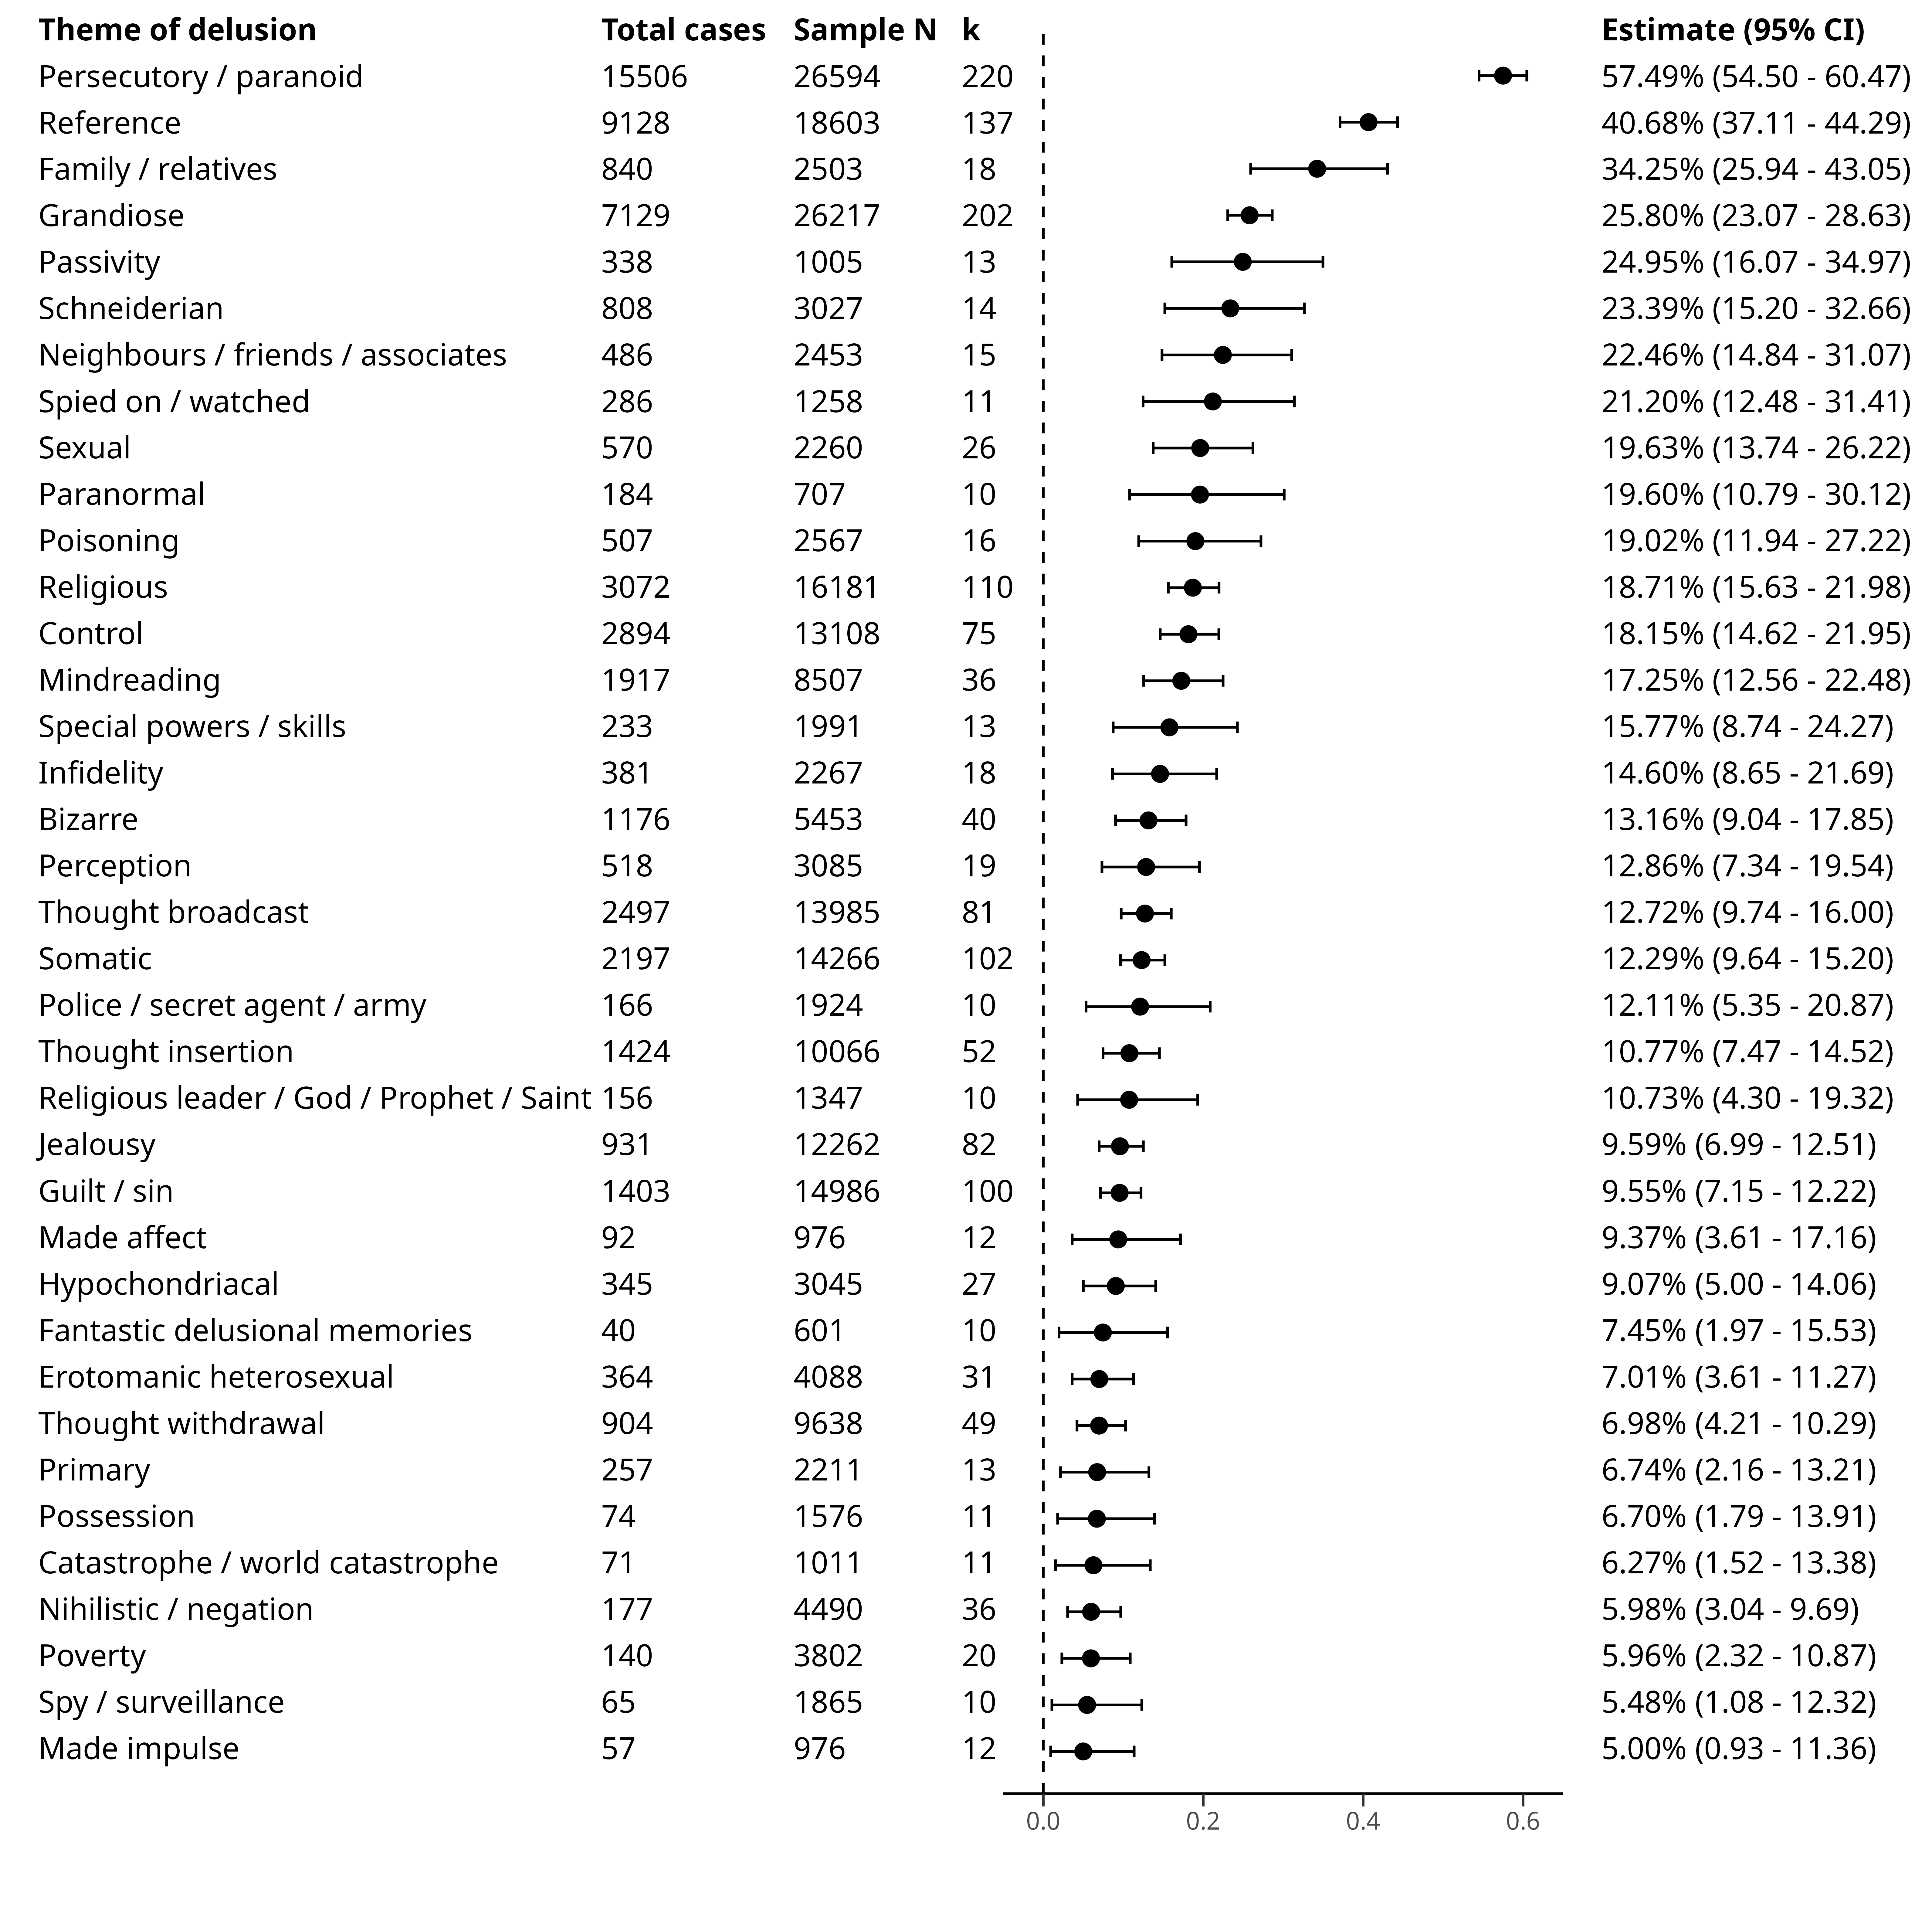

In [54]:
estimate_df_rho.3 <- run_meta(delus_themes_data_inclusive_recoded_min_k, rho_value = 0.3, sparse_option = FALSE)
check_if_estimates_altered_outside_prev_CIs(estimate_df_rho.3)
filename <- paste(output_dir, "figureS7_rho3_forest_plot.png", sep = "")
forester_plot(estimate_df_rho.3, max_ci_ub = 0.65, filename)
display_png(file = filename, width = 1000)

Sensitivity analysis with rho = 0.7

[1] FALSE

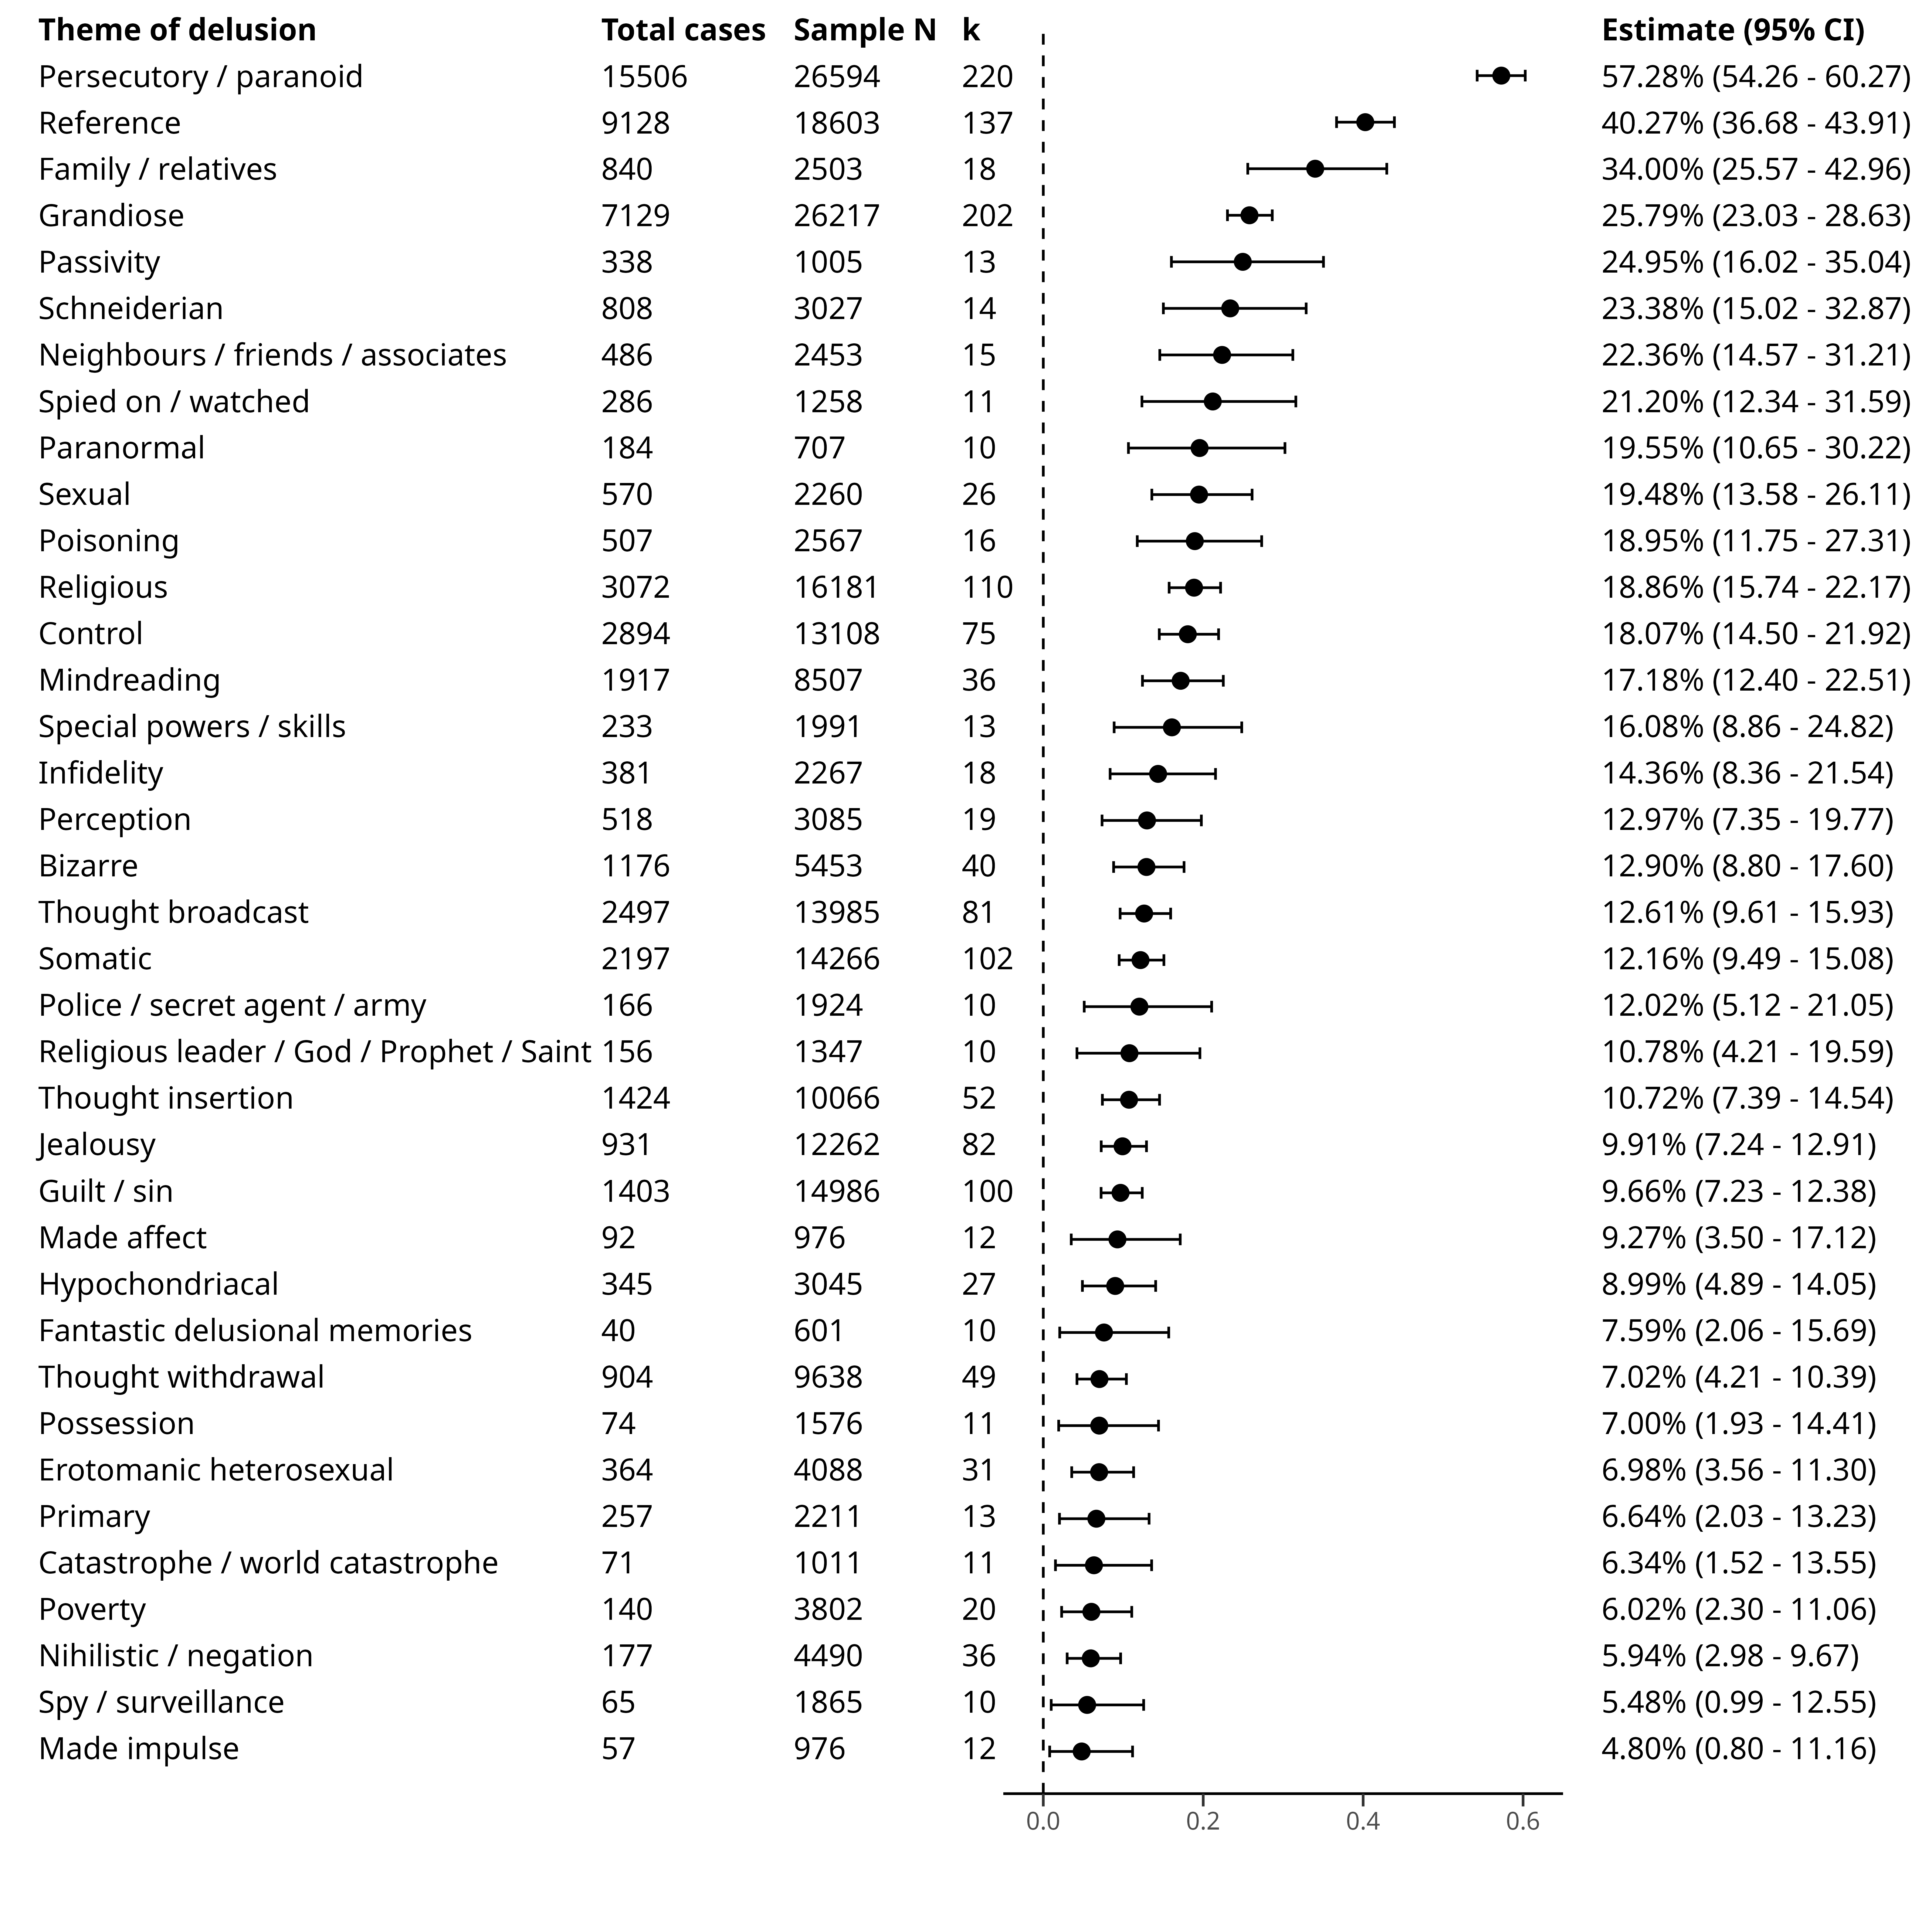

In [55]:
estimate_df_rho.7 <- run_meta(delus_themes_data_inclusive_recoded_min_k, rho_value = 0.7, sparse_option = FALSE)
check_if_estimates_altered_outside_prev_CIs(estimate_df_rho.7)
filename <- paste(output_dir, "figureS8_rho7_forest_plot.png", sep = "")
forester_plot(estimate_df_rho.7, max_ci_ub = 0.65, filename)
display_png(file = filename, width = 1000)

### Meta-analytic estimate of delusion count types (monothematic, polythematic, systemised)

In [56]:
delus_count_type_list <- c("polythematic", "monothematic", "mixed_multiple_various", "systemised")

delus_themes_data_count <- delus_themes_data %>% 
  filter(theme %in% delus_count_type_list)

delus_themes_data_count <- delus_themes_data_count %>%
  mutate(theme = recode(theme, "mixed_multiple_various" = "polythematic"))

estimate_df <- run_meta(delus_themes_data_count, sparse_option = FALSE)
estimate_df

theme        prevalence ci.lb     ci.ub     Total_cases psychotic_n k 
1 monothematic 0.4374932  0.2331676 0.6529773 234          965        11
2 polythematic 0.3665260  0.2391411 0.5036386 995         2426        27
3 systemised   0.3812638  0.2128134 0.5650526 975         2063        15
  est_str               
1 43.75% (23.32 - 65.30)
2 36.65% (23.91 - 50.36)
3 38.13% (21.28 - 56.51)

### Analysis platform and software version

In [57]:
version

               _                                          
platform       x86_64-pc-linux-gnu                        
arch           x86_64                                     
os             linux-gnu                                  
system         x86_64, linux-gnu                          
status         Patched                                    
major          4                                          
minor          2.2                                        
year           2022                                       
month          11                                         
day            10                                         
svn rev        83330                                      
language       R                                          
version.string R version 4.2.2 Patched (2022-11-10 r83330)
nickname       Innocent and Trusting                      

In [58]:
packageVersion("metafor")

[1] ‘4.4.0’

In [59]:
packageVersion("dplyr")

[1] ‘1.1.4’

In [60]:
packageVersion("stringr")

[1] ‘1.5.1’

In [61]:
packageVersion("forester")

[1] ‘0.2.0’

In [62]:
packageVersion("dmetar")

[1] ‘0.1.0’

In [63]:
packageVersion("doParallel")

[1] ‘1.0.17’

In [64]:
packageVersion("clubSandwich")

[1] ‘0.5.10’

In [65]:
packageVersion("mutoss")

[1] ‘0.1.13’

In [66]:
packageVersion("table1")

[1] ‘1.4.3’

In [67]:
packageVersion("flextable")

[1] ‘0.9.5’

In [68]:
packageVersion("tibble")

[1] ‘3.2.1’

In [69]:
packageVersion("IRdisplay")

[1] ‘1.1’